<a href="https://colab.research.google.com/github/ZackAkil/optimising-basketball/blob/master/shot%20prediction/where_did_i_shoot_from.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [1]:
!pip install tensorflowjs --quiet

tensorflow 1.12.0 has requirement keras-applications>=1.0.6, but you'll have keras-applications 1.0.4 which is incompatible.
tensorflow 1.12.0 has requirement keras-preprocessing>=1.0.5, but you'll have keras-preprocessing 1.0.2 which is incompatible.


In [2]:
!gsutil ls gs://rugby-videos

gs://rugby-videos/VID_20181215_095232.mp4
gs://rugby-videos/deltas.joblib
gs://rugby-videos/deltas.mp4
gs://rugby-videos/deltas_160.mp4
gs://rugby-videos/model.h5
gs://rugby-videos/model.json
gs://rugby-videos/model_where.h5
gs://rugby-videos/model_where.json
gs://rugby-videos/output_320_full.mp4
gs://rugby-videos/y.joblib


In [3]:
!gsutil cp gs://rugby-videos/deltas_160.mp4 .

Copying gs://rugby-videos/deltas_160.mp4...
- [1 files][  2.2 MiB/  2.2 MiB]                                                
Operation completed over 1 objects/2.2 MiB.                                      


In [0]:
DELTA_FILE_NAME = 'deltas_160.mp4'

In [5]:
!gsutil cp gs://rugby-videos/y.joblib .

Copying gs://rugby-videos/y.joblib...
- [1 files][ 28.4 KiB/ 28.4 KiB]                                                
Operation completed over 1 objects/28.4 KiB.                                     


In [0]:
from sklearn.externals import joblib
from scipy.misc import imresize

In [0]:
import matplotlib.pyplot as plt

In [0]:
ys = joblib.load('y.joblib')

In [0]:
!pip install scikit-video --quiet

In [0]:
from skvideo.io import vread
import numpy as np

In [0]:
X_delta = vread(DELTA_FILE_NAME)[:,:,:,0]
X = np.expand_dims(X_delta, axis=3)[:7000]
del(X_delta)

In [7]:
data_shape = X.shape
data_shape

(7000, 90, 160, 1)

In [0]:
# laod test data, making sure its from a different sequece completly

X_delta = vread(DELTA_FILE_NAME)[:,:,:,0]
X_test = (np.expand_dims(X_delta, axis=3)[7000:]/ 255.).astype(np.float16)
del(X_delta)

# turn y coords in to a boolean flag for 'was a shot taken'
valid_test_y = ~(np.array(ys['y'][7000:]) == None)


y_test = np.zeros([len(valid_test_y), 2])
y_test[:,0] = np.array(ys['x'][7000:]) 
y_test[:,1] = np.array(ys['y'][7000:])
y_test = y_test[valid_test_y]

y_test[:,0] /= 320.
y_test[:,1] /= 180.

X_test= X_test[valid_test_y]

In [9]:
X_test.max(), X_test.min(), y_test.max(), y_test.min()

(1.0, 0.0, 0.91875, 0.5)

In [10]:
X.shape

(7000, 90, 160, 1)

In [0]:
# turn y coords in to a boolean flag for 'was a shot taken'
Valid_y = ~(np.array(ys['y'][:7000]) == None)

In [0]:
y = np.zeros([len(Valid_y), 2])
y[:,0] = np.array(ys['x'][:7000]) 
y[:,1] = np.array(ys['y'][:7000])
y = y[Valid_y]

y[:,0] /= 320.
y[:,1] /= 180.

y[:,0] *= data_shape[2]
y[:,1] *= data_shape[1]

In [243]:
y

array([[183., 109.],
       [183., 109.],
       [183., 109.],
       ...,
       [228., 110.],
       [228., 110.],
       [228., 110.]])

In [0]:
shot_x = X[Valid_y]

In [14]:
# original shape 180 320
y.min(axis=0), y.max(axis=0)

(array([86.5, 52.5]), array([120.,  58.]))

# Augment data
shift up and across X and y

In [15]:
y.min(axis=0), y.max(axis=0)

(array([86.5, 52.5]), array([120.,  58.]))

In [0]:
y_m = len(y)

In [17]:
x_trans_m = 4
x_trans = (np.arange(x_trans_m)*20)-30
x_trans

array([-30, -10,  10,  30])

In [18]:
y_trans_m = 4
y_trans = (np.arange(y_trans_m)*10)-15
y_trans

array([-15,  -5,   5,  15])

In [19]:
new_data = np.zeros([(y_m * x_trans_m) * (y_trans_m+1), data_shape[1], data_shape[2], 1]).astype(np.uint8)
new_y_data = np.zeros([(y_m * x_trans_m) * (y_trans_m+1), 2])
new_data.shape, new_y_data.shape

NameError: ignored

In [20]:
# X axis translation augmentation 
offset = 0

for i, trans in enumerate(x_trans):
  from_index = i*y_m
  to_index = (i+1)*y_m
  print('writing {0} to {1}, translation of {2}'.format(from_index, to_index, trans))
  offset = to_index
  
  
  new_data[from_index:to_index] = np.roll(shot_x, trans)
  print(new_data.sum())
  
  new_y_data[from_index:to_index, 0] = y[:,0] + trans
  new_y_data[from_index:to_index, 1] = y[:,1]
  
  print('traslated y {0}'.format(new_y_data.sum()))
  
  print(y[8,0],  y[8,0] + trans)

writing 0 to 711, translation of -30
158356684
traslated y 92217.0
91.5 61.5
writing 711 to 1422, translation of -10
316713368
traslated y 198654.0
91.5 81.5
writing 1422 to 2133, translation of 10
475070052
traslated y 319311.0
91.5 101.5
writing 2133 to 2844, translation of 30
633426736
traslated y 454188.0
91.5 121.5


10
[61.5 54.5]


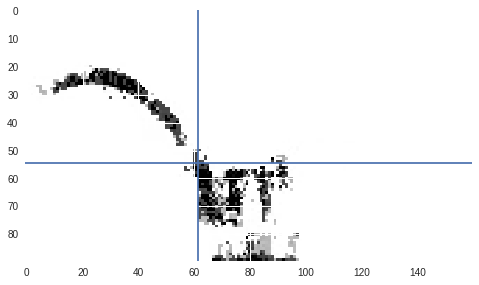

721
[81.5 54.5]


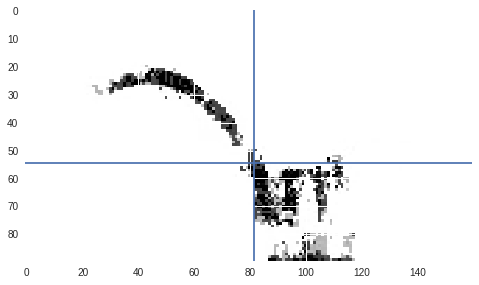

1432
[101.5  54.5]


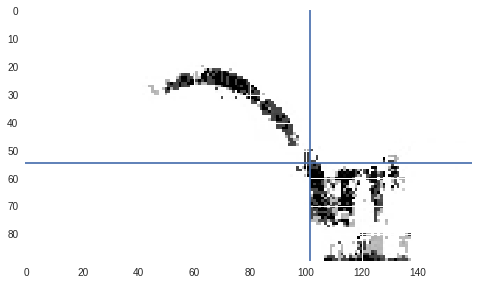

2143
[121.5  54.5]


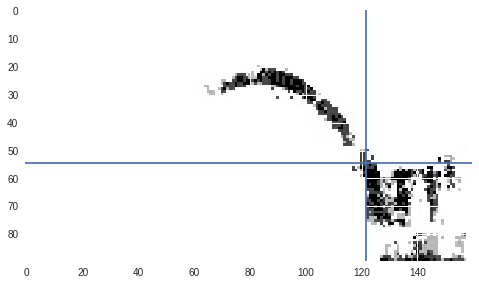

2854
[0. 0.]


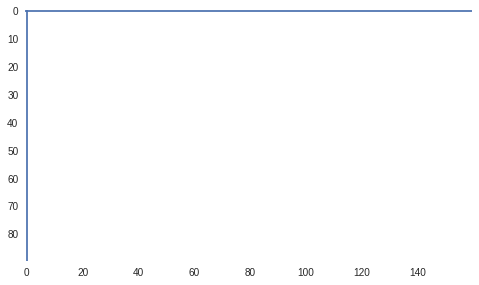

In [23]:
start_index = 10;

for i in range(y_trans_m+1):
  index_to_display = (i * y_m) + start_index
  print(index_to_display)
  plt.imshow(new_data[index_to_display,:,:,0])
  
  print(new_y_data[index_to_display])
  plt.axvline(new_y_data[index_to_display, 0]  )
  plt.axhline(new_y_data[index_to_display, 1] )
  plt.show()

In [24]:
# X axis translation augmentation 


starting_data = new_data[:offset]
starting_y = new_y_data[:offset]

for i, trans in enumerate(y_trans):
  
  from_index = (i*offset) + offset
  to_index = ((i+1)*offset) + offset
  print('writing {0} to {1}, translation of {2}'.format(from_index, to_index, trans))
  
  
  new_data[from_index:to_index] = np.roll(starting_data, trans, axis=1)
  print(new_data.sum())
  
  new_y_data[from_index:to_index, 1] = starting_y[:,1] + trans
  new_y_data[from_index:to_index, 0] = starting_y[:,0]
  
  print('traslated y {0}'.format(new_y_data.sum()))

writing 2844 to 5688, translation of -15
1266853472
traslated y 865716.0
writing 5688 to 8532, translation of -5
1900280208
traslated y 1305684.0
writing 8532 to 11376, translation of 5
2533706944
traslated y 1774092.0
writing 11376 to 14220, translation of 15
3167133680
traslated y 2270940.0


In [0]:
new_y = new_y_data
new_y[:,0] /= data_shape[2]
new_y[:,1] /= data_shape[1]

In [35]:
new_data.sum(axis=(1,2,3)).min(), new_data.sum(axis=(1,2,3)).max()

(141473, 392505)

In [36]:
y.shape, X.shape

((711, 2), (7000, 90, 160, 1))

In [37]:
new_y.min(axis=0), new_y.max(axis=0)

(array([0.353125  , 0.41666667]), array([0.9375    , 0.81111111]))

In [0]:
def show_random_frames(X, y):
  
  random_indexes = np.random.choice(range(len(y)), 5)

  # confirm that our y match with frames with shots
  for index in random_indexes:
    
    plt.imshow(X[index])
    plt.axvline(y[index, 0]*data_shape[2])
    plt.axhline(y[index, 1]*data_shape[1])
    plt.show()

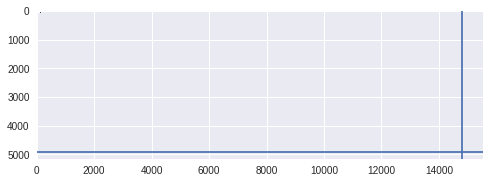

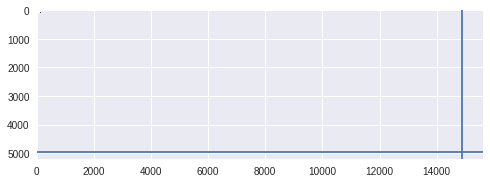

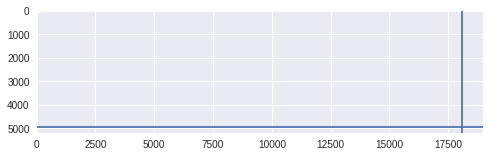

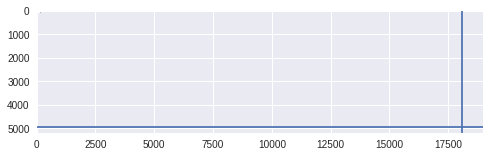

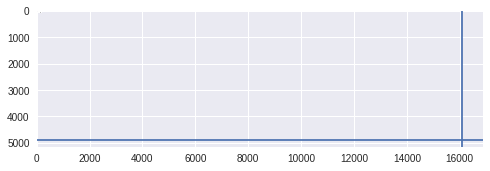

In [319]:
temp_y = y.copy()
temp_y[:,0] 
temp_y[:,1] 

show_random_frames(shot_x[:,:,:,0], y)

In [320]:
new_data.shape, new_data.min(), new_data.max()

((14220, 90, 160, 1), 0, 255)

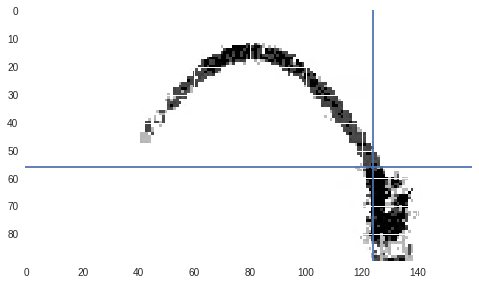

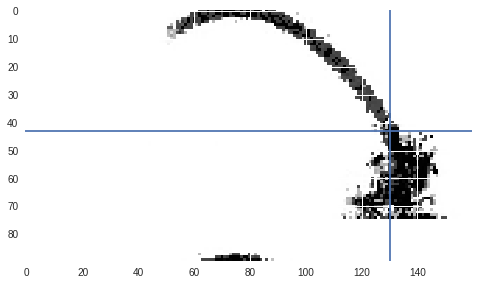

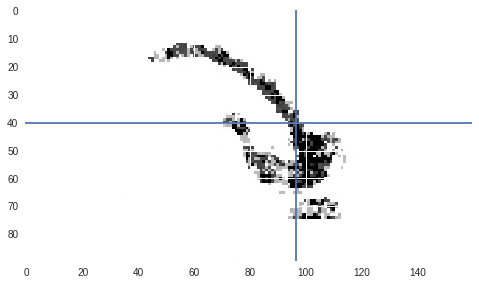

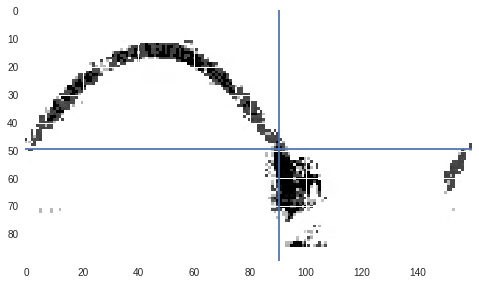

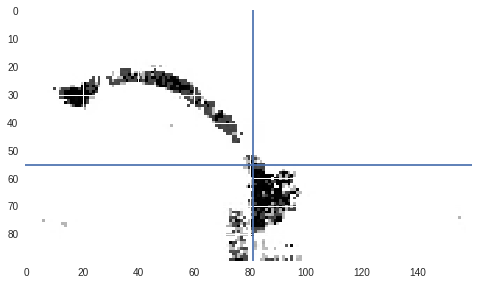

In [39]:
show_random_frames(new_data[:,:,:,0], new_y)

In [123]:
new_data.max(), new_data.min()

(255, 0)

In [0]:
X_train = new_data
y_train = new_y

X_train = (X_train / 255.).astype(np.float16)
# X_test = (X_test / 255.).astype(np.float16)

In [42]:
X_train.max(), X_train.min(), y_train.max(axis=0), y_train.min(axis=0)

(1.0, 0.0, array([0.9375    , 0.81111111]), array([0.353125  , 0.41666667]))

In [76]:
new_data[1].sum()

165195

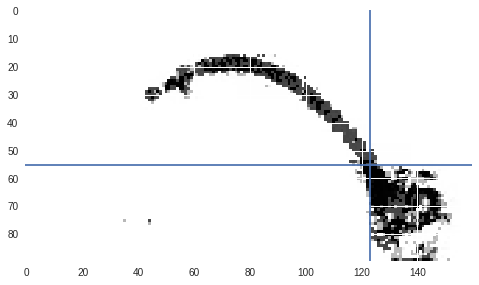

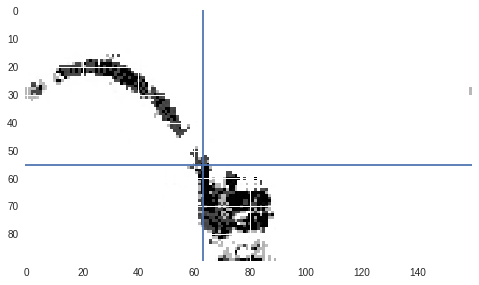

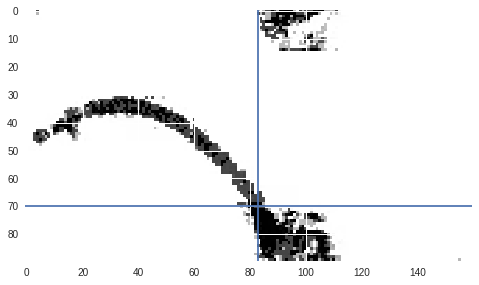

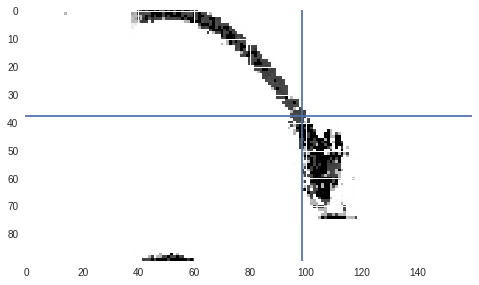

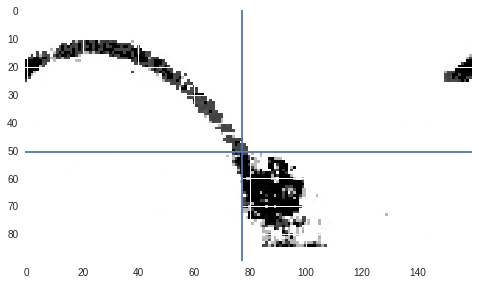

In [45]:
show_random_frames( (X_train[:,:,:,0]*255).astype(np.uint8), y_train)

In [46]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [47]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [48]:
X_train.max(), X_train.min(), y_train.max(), y_train.min()

(1.0, 0.0, 0.9375, 0.353125)

In [49]:
X_test.max(), X_test.min(), y_test.max(), y_test.min()

(1.0, 0.0, 0.91875, 0.5)

In [0]:
input_shape = (data_shape[1], data_shape[2], 1)

In [0]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='linear'))

In [0]:
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam())

In [53]:
y_train.shape, X_train.shape

((14220, 2), (14220, 90, 160, 1))

In [54]:
y_test.shape, X_test.shape

((528, 2), (528, 90, 160, 1))

In [67]:
batch_size = 128
epochs = 5


model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 14220 samples, validate on 528 samples
Epoch 1/5
14220/14220 [==============================] - 9s 605us/step - loss: 0.0057 - val_loss: 0.0013
Epoch 2/5
14220/14220 [==============================] - 8s 592us/step - loss: 0.0058 - val_loss: 0.0016
Epoch 3/5
14220/14220 [==============================] - 8s 594us/step - loss: 0.0057 - val_loss: 0.0015
Epoch 4/5
14220/14220 [==============================] - 8s 590us/step - loss: 0.0057 - val_loss: 0.0015
Epoch 5/5
14220/14220 [==============================] - 8s 592us/step - loss: 0.0057 - val_loss: 0.0014


In [0]:
def gray_to_channel(image):
  new_image = np.zeros([*image.shape[:2], 3])
  new_image[:,:,0] = image.reshape(image.shape[:2])
  new_image[:,:,1] = image.reshape(image.shape[:2])
  new_image[:,:,2] = image.reshape(image.shape[:2])
  return new_image

In [0]:
test_imge = gray_to_channel(X_test[1])


In [144]:
test_imge.sum()

1627.407211303711

In [0]:
def show_frames(X, y, m=10, true_y=None):
  print(X.shape, y.shape)
  

  for i in range(m):
    
    plt.imshow(gray_to_channel(X[i]))
    plt.axvline(y[i, 0]*data_shape[2])
    plt.axhline(y[i, 1]*data_shape[1])
    
    if true_y is not None:
      plt.axvline(true_y[i, 0]*data_shape[2], c='r')
      plt.axhline(true_y[i, 1]*data_shape[1], c='r')
      
    
    plt.grid(False)
    plt.show()

In [72]:
y_test

array([[0.5625    , 0.61111111],
       [0.5625    , 0.61111111],
       [0.5625    , 0.61111111],
       ...,
       [0.5       , 0.62777778],
       [0.5       , 0.62777778],
       [0.5       , 0.62777778]])

In [135]:
X_test.min(), X_test.max()

(0.0, 0.00392)

In [136]:
X_train.min(), X_train.max()

(0.0, 1.0)

(474, 90, 160, 1) (474, 2)


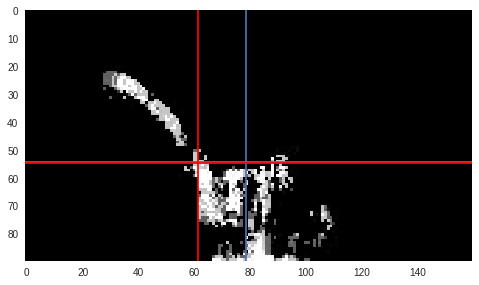

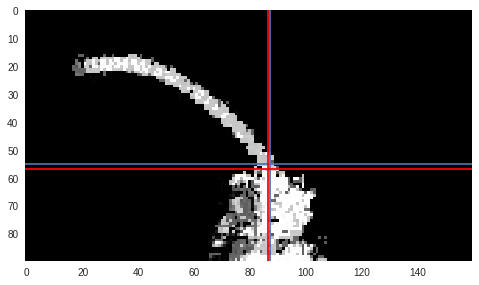

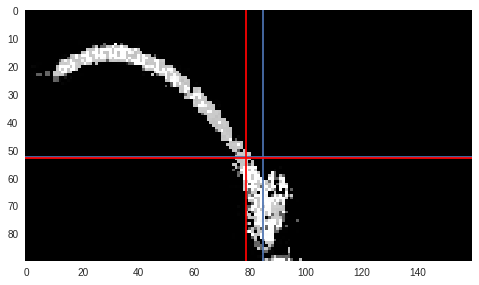

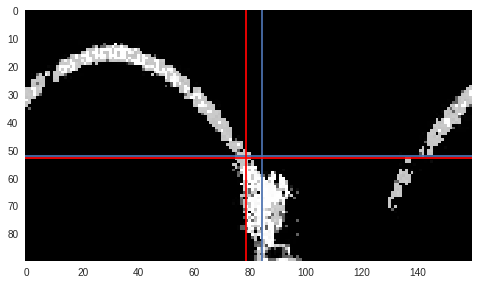

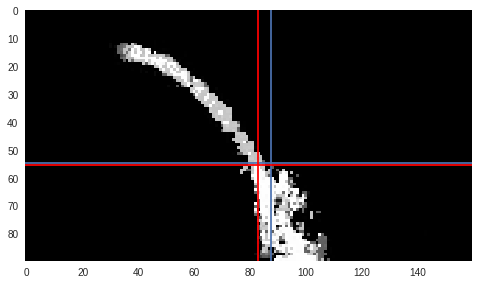

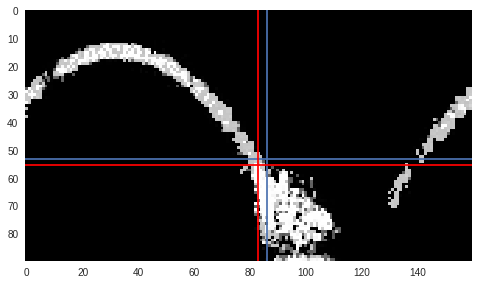

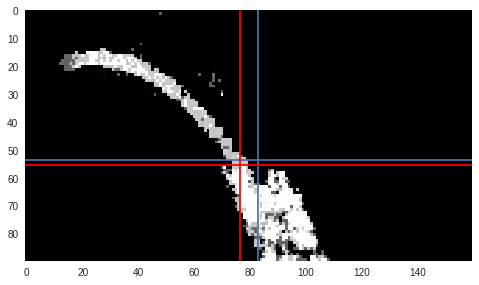

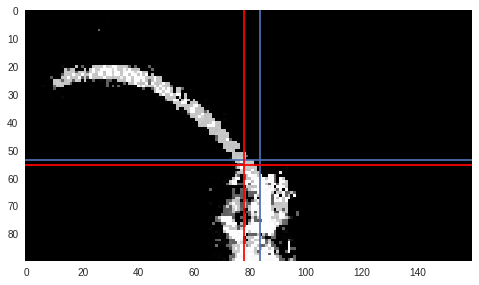

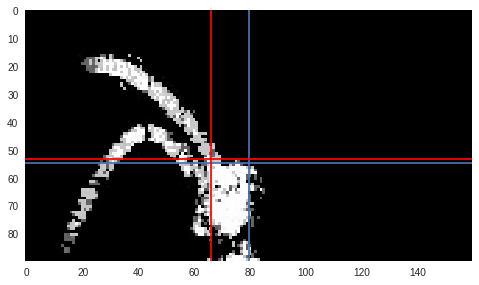

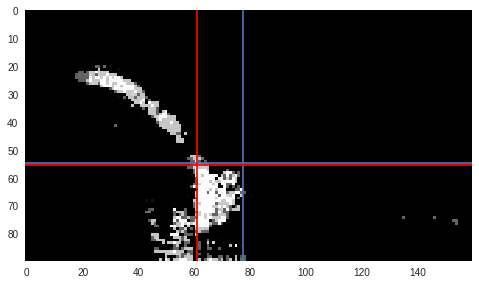

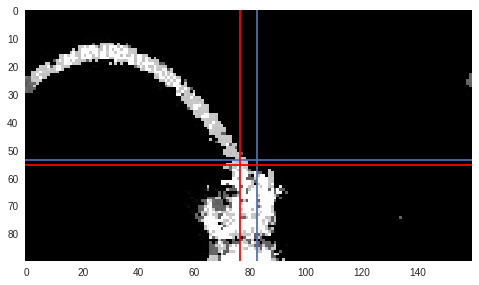

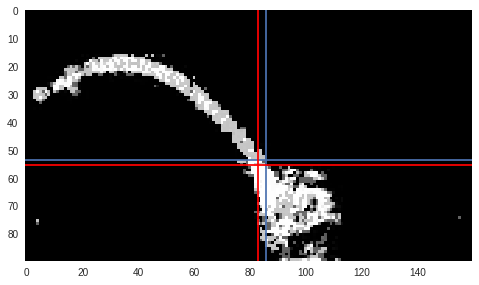

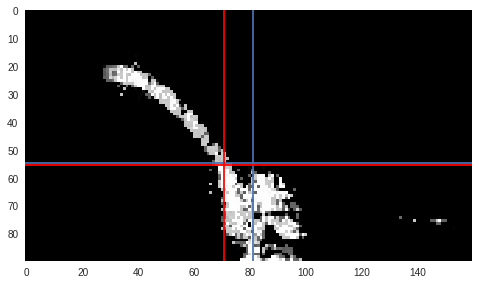

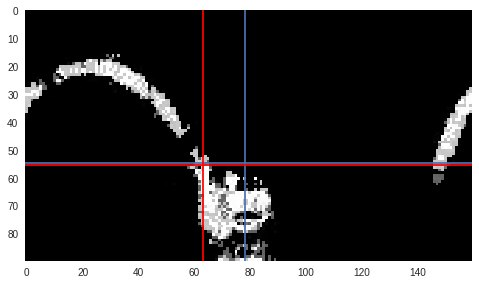

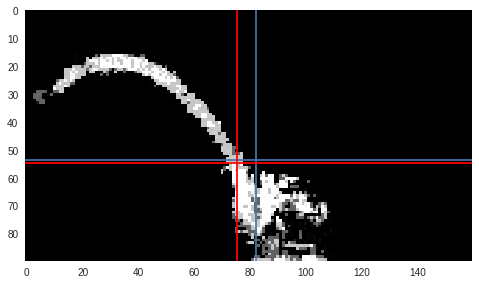

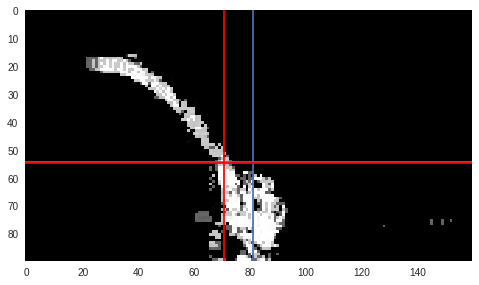

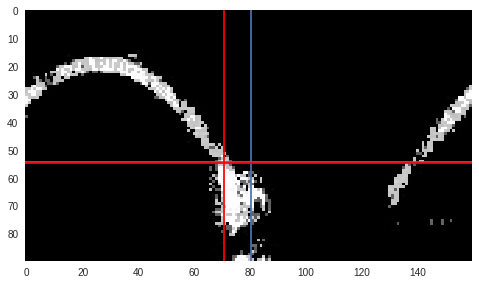

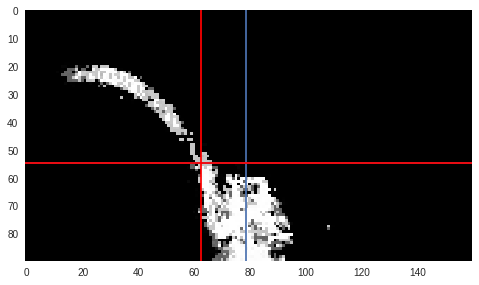

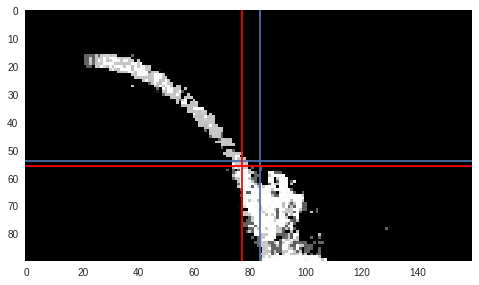

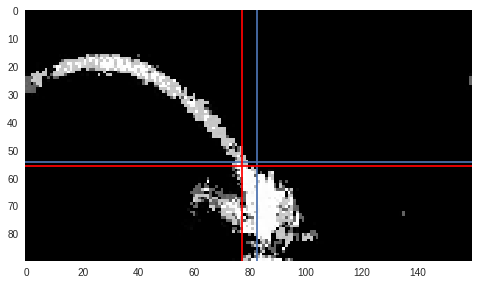

In [68]:
pred = model.predict(X_train)
show_frames(X_train[::30], pred[::30], m=20, true_y=y_train[::30])

(53, 90, 160, 1) (53, 2)


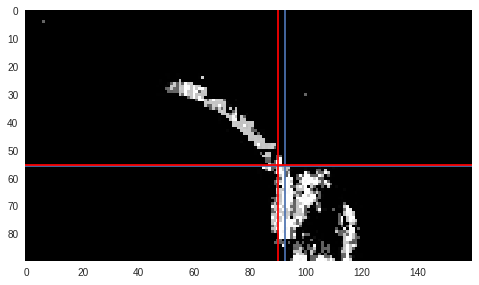

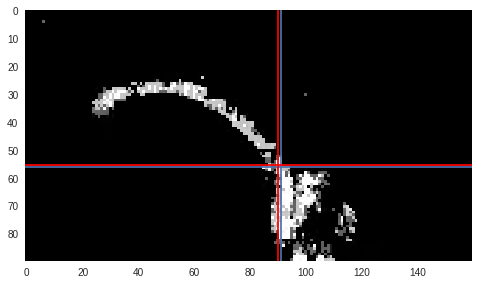

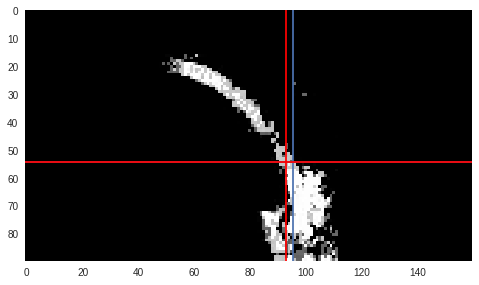

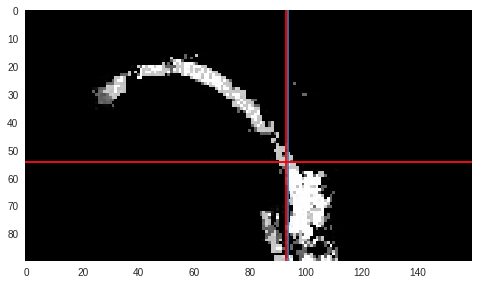

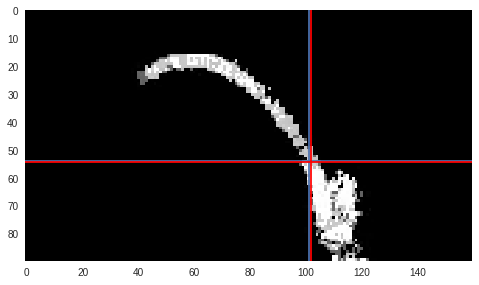

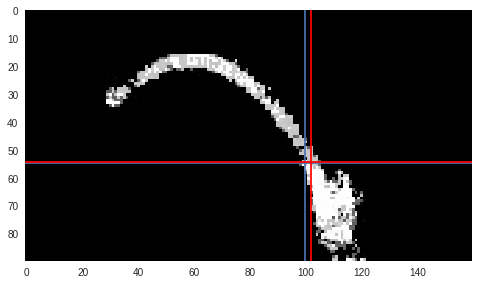

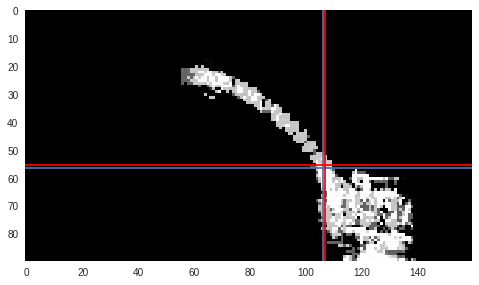

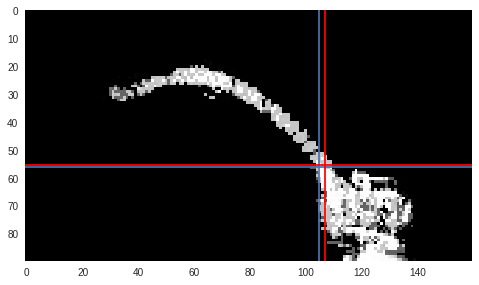

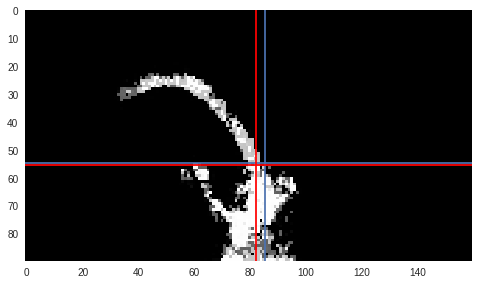

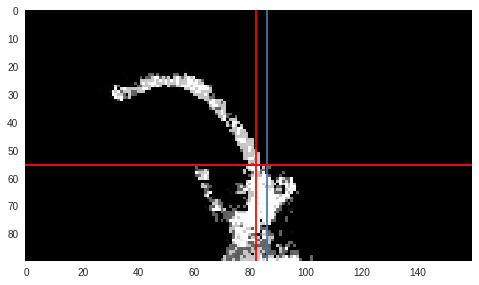

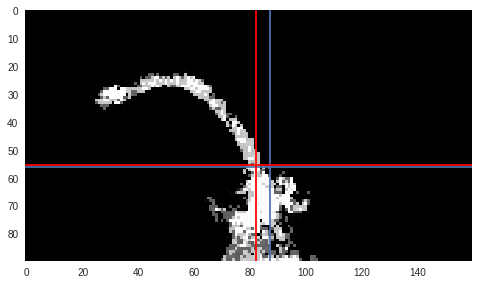

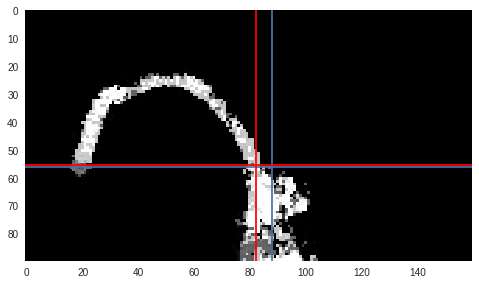

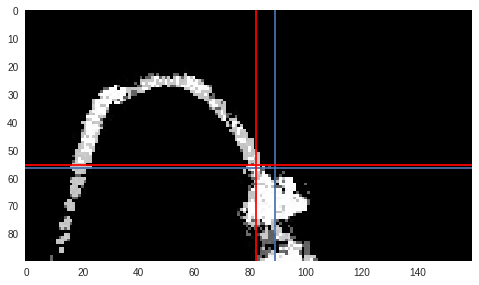

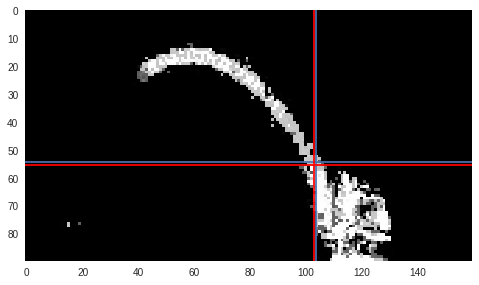

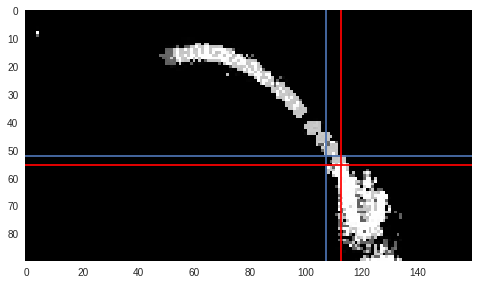

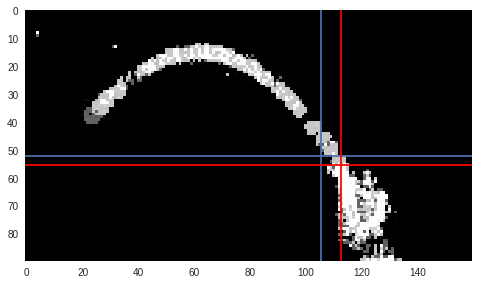

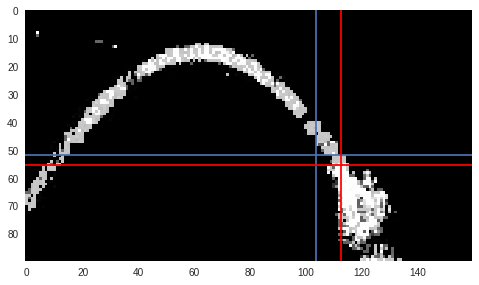

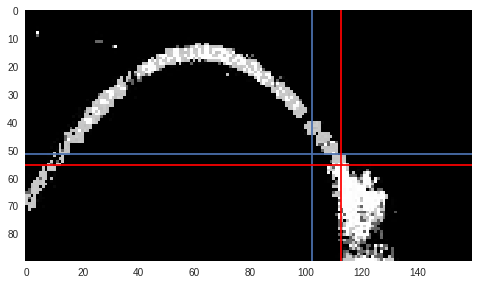

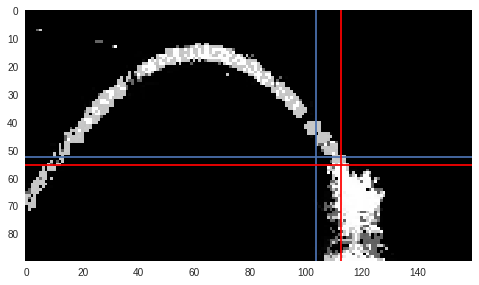

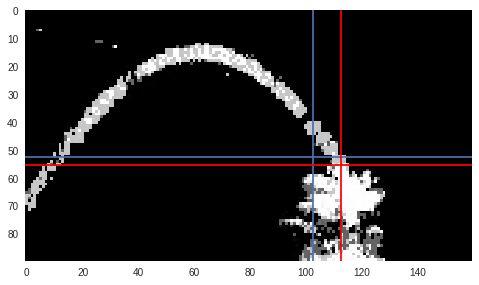

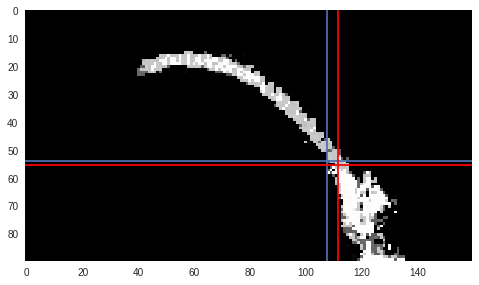

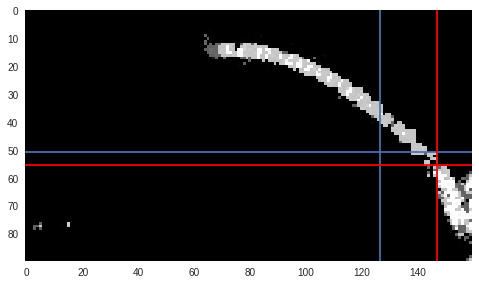

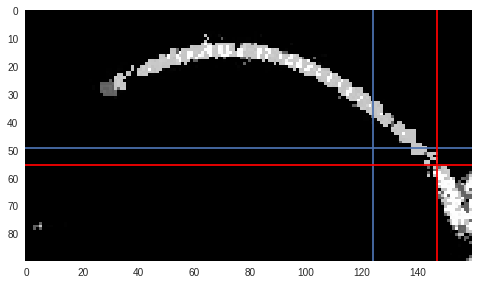

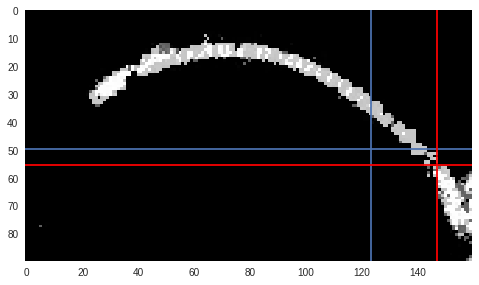

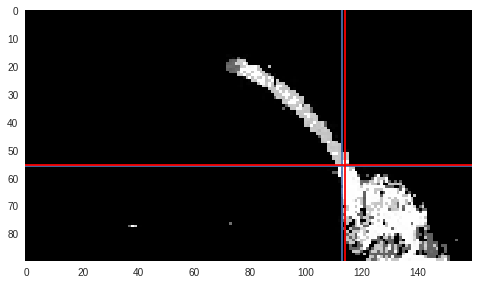

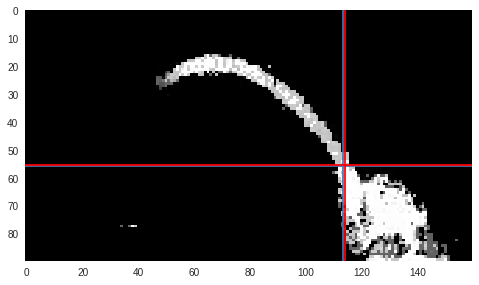

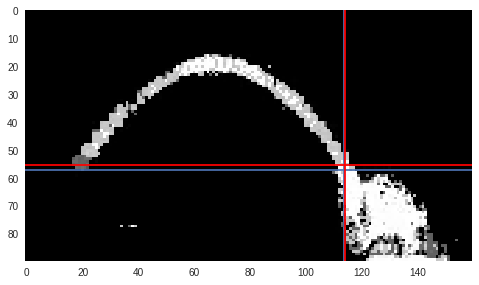

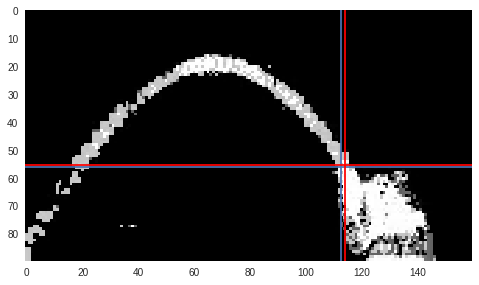

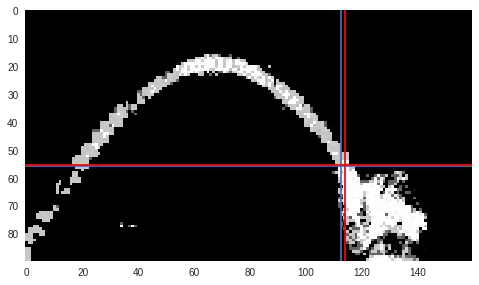

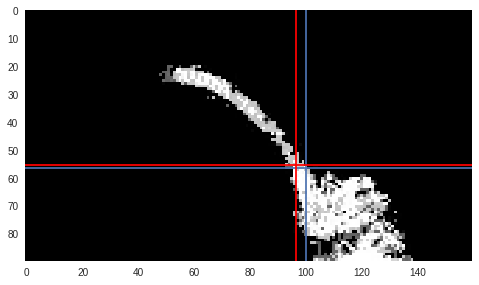

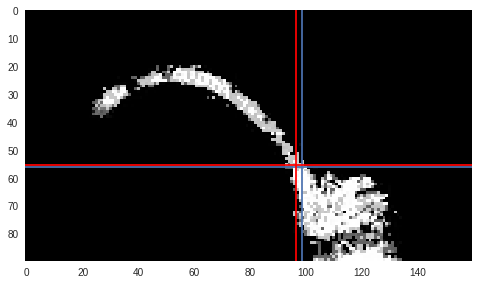

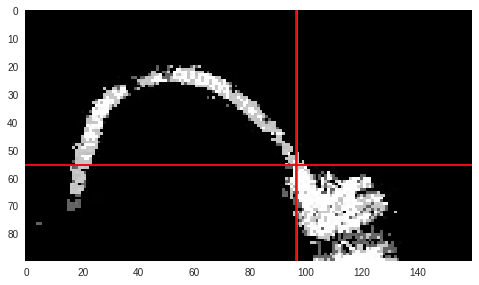

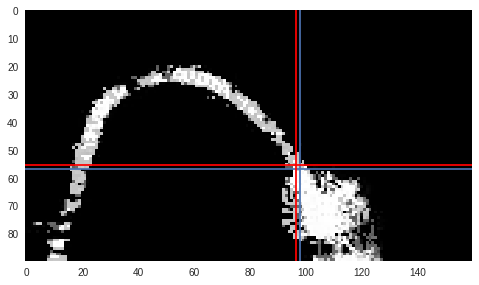

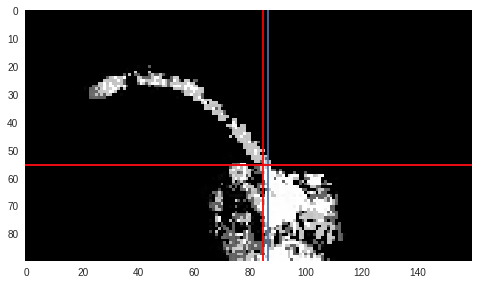

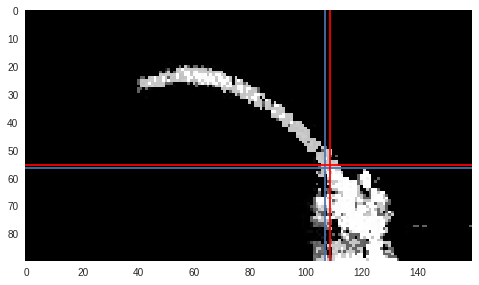

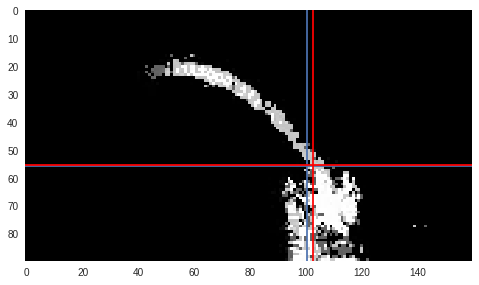

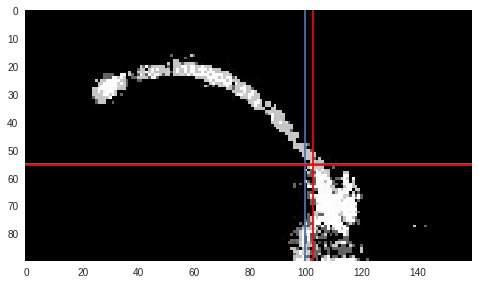

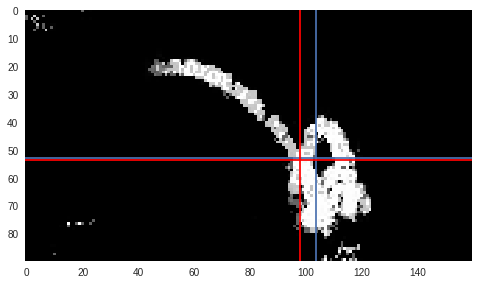

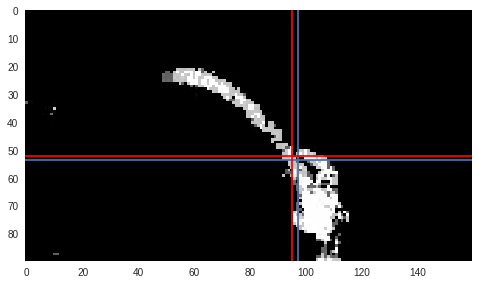

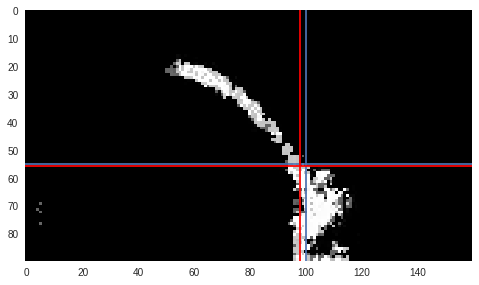

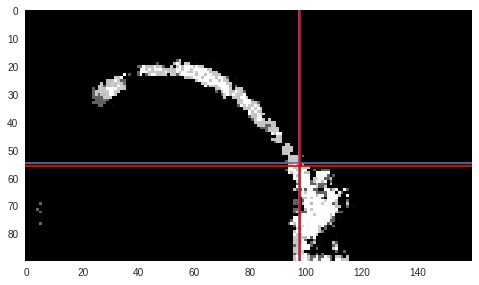

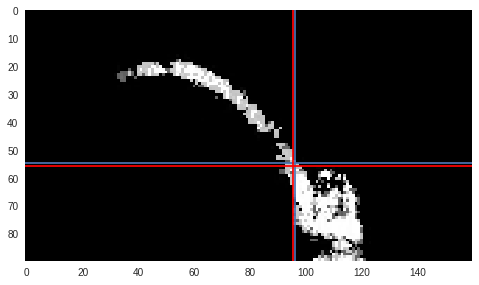

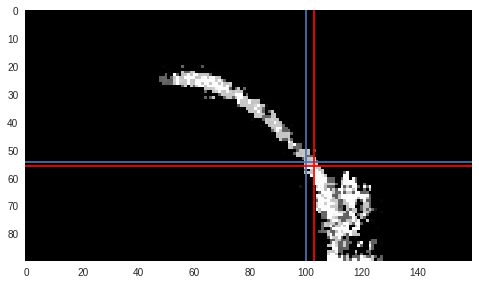

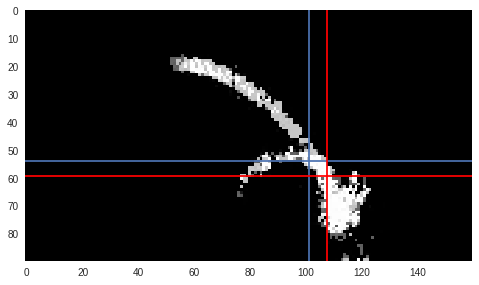

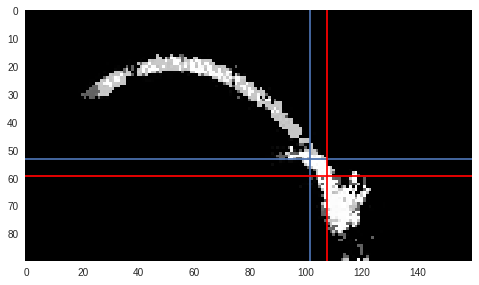

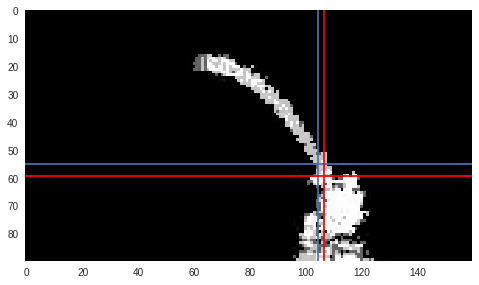

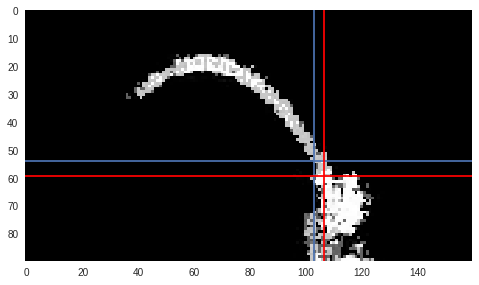

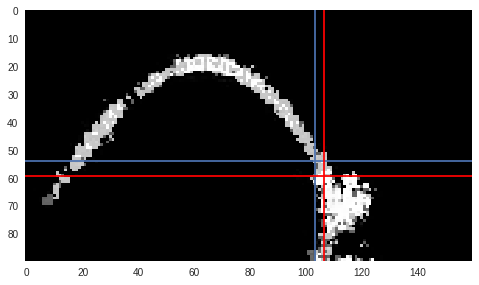

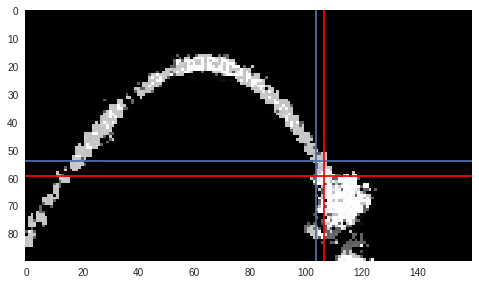

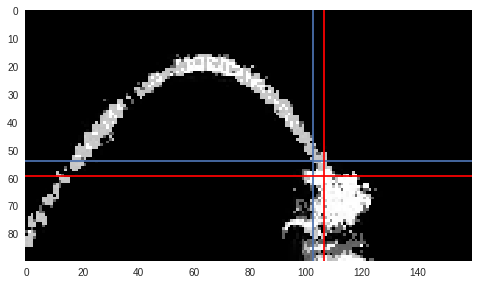

In [69]:
pred = model.predict(X_test)
show_frames(X_test[::10], pred[::10], m=50,  true_y=y_test[::10])

https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

Saved model to disk


In [0]:
! gsutil cp model.h5 gs://rugby-videos/model_where.h5

Copying file://model.h5 [Content-Type=application/octet-stream]...
/ [1 files][  1.8 MiB/  1.8 MiB]                                                
Operation completed over 1 objects/1.8 MiB.                                      


In [0]:
! gsutil cp model.json gs://rugby-videos/model_where.json

Copying file://model.json [Content-Type=application/json]...
/ [1 files][  2.2 KiB/  2.2 KiB]                                                
Operation completed over 1 objects/2.2 KiB.                                      


In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 88, 158, 16)       160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 156, 8)        1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 78, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 43, 78, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 26832)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                429328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
__________

In [0]:
import tensorflowjs as tfjs


In [0]:

tfjs.converters.save_keras_model(model, 'js')

In [72]:
! zip -r js_model.zip js

updating: js/ (stored 0%)
updating: js/model.json (deflated 79%)
updating: js/group1-shard1of1 (deflated 7%)
